_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-05-27 11:33:49CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

sklearn: 1.4.2

matplotlib: 3.8.4
numpy     : 1.26.4
scipy     : 1.13.0
pandas    : 2.2.2
seaborn   : 0.13.2

Watermark: 2.4.3



In [ ]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [ ]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

In [ ]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [ ]:
ogb_spikes.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


In [ ]:
ogb_calcium.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.234928,0.689186,2.578560,0.636770,-0.015140,0.819771,2.442105,0.391310,0.223523,1.557675,0.625052
1,-0.182441,0.869132,2.868601,0.596164,0.022464,0.831411,2.930201,0.490213,0.116095,1.628054,0.638718
2,-0.049257,0.949273,2.784989,0.711875,0.040028,0.877191,3.065872,0.610873,0.154437,1.479382,0.552809
3,-0.032876,0.848802,2.430735,0.940943,0.038616,0.975941,3.051014,0.714453,0.335288,1.302766,0.420998
4,-0.125313,0.665088,2.064211,1.168007,0.014035,1.156689,2.967063,0.737085,0.550485,1.234470,0.367595


In [ ]:
# resampling from 100 Hz to 25 Hz

# convert dataframe to numpy
rs_ogb_calcium = ogb_calcium.to_numpy()
rs_ogb_spikes = ogb_spikes.to_numpy()
rs_gcamp_calcium = gcamp_calcium.to_numpy()
rs_gcamp_spikes = gcamp_spikes.to_numpy()

# ADDED: set all NaN values to 0, otherwise decimate only returns NaN for that column...
rs_ogb_calcium[np.isnan(rs_ogb_calcium)] = 0
rs_ogb_spikes[np.isnan(rs_ogb_spikes)] = 0
rs_gcamp_calcium[np.isnan(rs_gcamp_calcium)] = 0
rs_gcamp_spikes[np.isnan(rs_gcamp_spikes)] = 0

# resample
orignal_freq = 100
new_freq = 25
downsample_factor = orignal_freq // new_freq
filter_order = 0
dt = 1 / new_freq

rs_ogb_calcium = signal.decimate(rs_ogb_calcium[:-2, :], q=downsample_factor, axis=0)
rs_ogb_spikes = signal.decimate(rs_ogb_spikes[:-2, :], q=downsample_factor, axis=0)
rs_gcamp_calcium = signal.decimate(
    rs_gcamp_calcium[:-1, :], q=downsample_factor, axis=0
)
rs_gcamp_spikes = signal.decimate(rs_gcamp_spikes[:-1, :], q=downsample_factor, axis=0)

# set all < 0 to 0 and all > 0 to 1
rs_ogb_spikes[rs_ogb_spikes >= 0.1] = 1
rs_ogb_spikes[rs_ogb_spikes < 0.1] = 0
rs_gcamp_spikes[rs_gcamp_spikes >= 0.1] = 1
rs_gcamp_spikes[rs_gcamp_spikes < 0.1] = 0

ogb_cell_5_calcium = rs_ogb_calcium[:, 4]
ogb_cell_5_spikes = rs_ogb_spikes[:, 4]
gcamp_cell_6_calcium = rs_gcamp_calcium[:, 5]
gcamp_cell_6_spikes = rs_gcamp_spikes[:, 5]

ogb_cell_5_calcium.shape

(17996,)

In [ ]:
rs_gcamp_spikes.max()

1.0

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

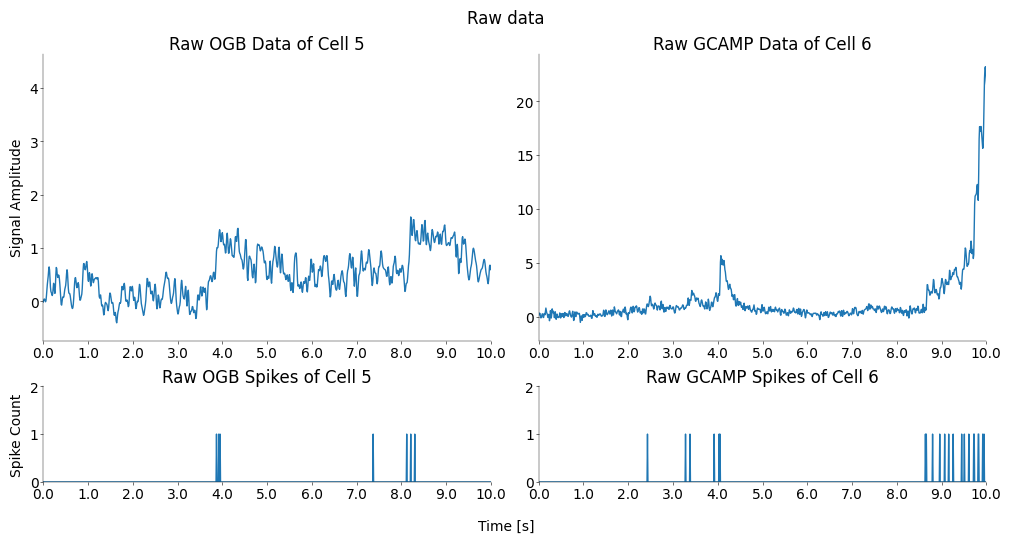

In [ ]:
# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------

# --------------------------
# Plot raw spike data (1 pt)
# --------------------------

fig, axs = plt.subplots(
    2, 2, figsize=(10, 5), height_ratios=[3, 1], layout="constrained"
)

# TODO shared x axis?


# plot raw ogb data
ogb_calcium_lane = ogb_calcium.iloc[:, 4]
axs[0, 0].plot(np.arange(0, len(ogb_calcium_lane)), ogb_calcium_lane)
axs[0, 0].set_title("Raw OGB Data of Cell 5")
axs[0, 0].set_ylabel("Signal Amplitude")

ogb_spikes_lane = ogb_spikes.iloc[:, 4]
axs[1, 0].plot(np.arange(0, len(ogb_spikes_lane)), ogb_spikes_lane)
axs[1, 0].set_title("Raw OGB Spikes of Cell 5")
axs[1, 0].set_ylim(0, 2)
axs[1, 0].set_ylabel("Spike Count")


# plot raw gcamp data
gcamp_calcium_lane = gcamp_calcium.iloc[:, 5]
axs[0, 1].plot(np.arange(0, len(gcamp_calcium_lane)), gcamp_calcium_lane)
axs[0, 1].set_title("Raw GCAMP Data of Cell 6")

gcamp_spikes_lane = gcamp_spikes.iloc[:, 5]
axs[1, 1].plot(np.arange(0, len(gcamp_spikes_lane)), gcamp_spikes_lane)
axs[1, 1].set_title("Raw GCAMP Spikes of Cell 6")
axs[1, 1].set_ylim(0, 2)

for ax in axs.flat:
    ax.set_xlim(0, 1000)
    # set x ticks to seconds
    ax.set_xticks(np.arange(0, 1001, 100))
    ax.set_xticklabels(np.arange(0, 1001, 100) / 100)
# global x label for time in s
fig.text(0.5, -0.05, "Time [s]", ha="center")

plt.suptitle("Raw data")
plt.show()

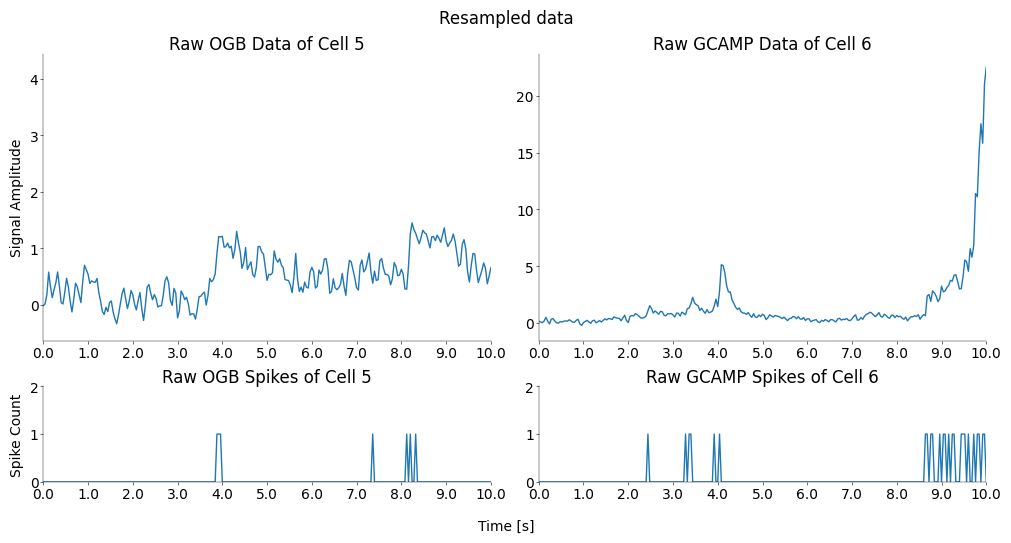

In [ ]:
fig, axs = plt.subplots(
    2, 2, figsize=(10, 5), height_ratios=[3, 1], layout="constrained"
)

# plot raw ogb data
axs[0, 0].plot(np.arange(0, rs_ogb_calcium.shape[0]), ogb_cell_5_calcium)
axs[0, 0].set_title("Raw OGB Data of Cell 5")
axs[0, 0].set_ylabel("Signal Amplitude")

axs[1, 0].plot(np.arange(0, rs_ogb_spikes.shape[0]), ogb_cell_5_spikes)
axs[1, 0].set_title("Raw OGB Spikes of Cell 5")
axs[1, 0].set_ylim(0, 2)
axs[1, 0].set_ylabel("Spike Count")

axs[0, 1].plot(np.arange(0, rs_gcamp_calcium.shape[0]), gcamp_cell_6_calcium)
axs[0, 1].set_title("Raw GCAMP Data of Cell 6")

axs[1, 1].plot(np.arange(0, rs_gcamp_spikes.shape[0]), gcamp_cell_6_spikes)
axs[1, 1].set_title("Raw GCAMP Spikes of Cell 6")
axs[1, 1].set_ylim(0, 2)

for ax in axs.flat:
    ax.set_xlim(0, 250)
    ax.set_xticks(np.arange(0, 251, 25))
    ax.set_xticklabels(np.arange(0, 251, 25) / 25)
# global x label for time in s
fig.text(0.5, -0.05, "Time [s]", ha="center")

plt.suptitle("Resampled data")
plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


In [ ]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # insert your code here

    # --------------------------------------------
    # apply deconvolution to calcium signal (1 pt)
    # --------------------------------------------

    t_kernel = np.arange(0, tau, dt)
    kernel = np.exp(-t_kernel / tau)
    kernel = kernel / np.sum(kernel)

    # deconvolution
    sp_hat, _ = signal.deconvolve(ca, kernel)

    # set all values of sp_hat < 0 to 0
    return np.maximum(sp_hat, 0)

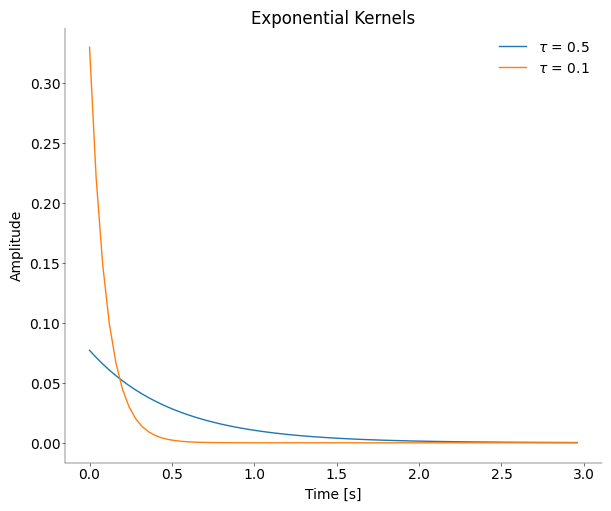

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

for tau in [0.5, 0.1]:
    t_kernel = np.arange(0, 3, dt)
    kernel = np.exp(-t_kernel / tau)
    kernel = kernel / np.sum(kernel)
    ax.plot(t_kernel, kernel, label=f"$\\tau$ = {tau}")

ax.set_title("Exponential Kernels")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")  # TODO mag dieses Label nicht
ax.legend()
plt.show()

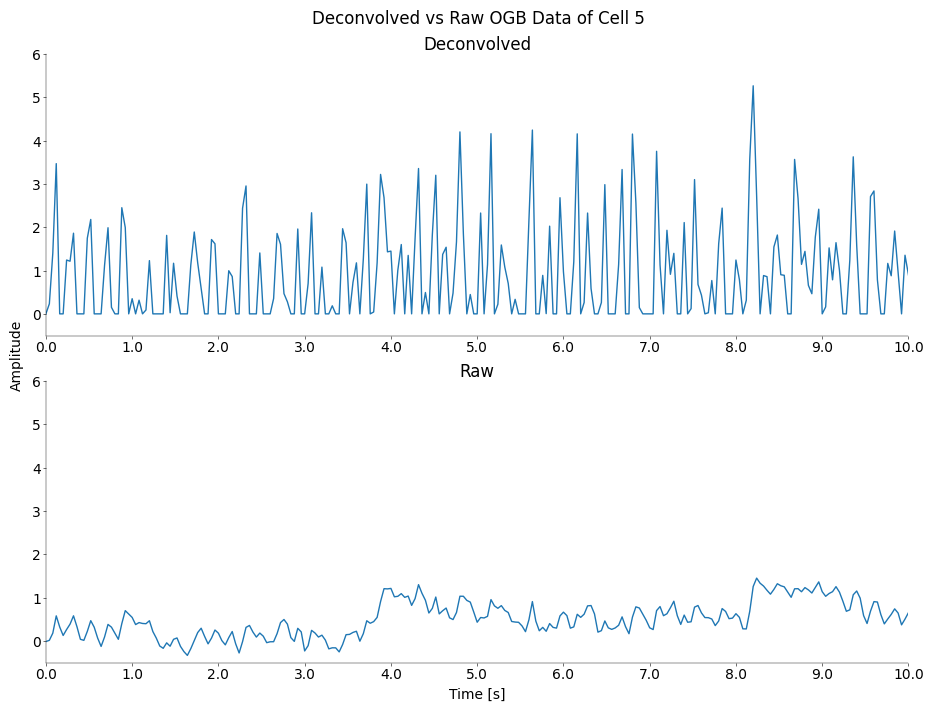

In [ ]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

sp_hat_ogb = deconv_ca(ogb_cell_5_calcium, 0.5, dt)
sp_hat_gcamp = deconv_ca(gcamp_cell_6_calcium, 0.1, dt)

fig, axs = plt.subplots(
    2, 1, figsize=(9, 7), layout="constrained", height_ratios=[1, 1]
)

axs[0].plot(np.arange(0, len(sp_hat_ogb)), sp_hat_ogb)
axs[0].set_title("Deconvolved")

axs[1].plot(np.arange(0, len(ogb_cell_5_calcium)), ogb_cell_5_calcium)
axs[1].set_title("Raw")
axs[1].set_xlabel("Time [s]")


for ax in axs.flat:
    ax.set_xlim(0, 250)
    ax.set_xticks(np.arange(0, 251, 25))
    ax.set_xticklabels(np.arange(0, 251, 25) / 25)
    ax.set_ylim(-0.5, 6)
# add shared y label
fig.text(-0.02, 0.5, "Amplitude", va="center", rotation="vertical")

plt.suptitle("Deconvolved vs Raw OGB Data of Cell 5")
plt.show()

# TODO was ist mit scale to facilitate comparison gemeint?

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [ ]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py

--2024-05-27 11:33:52--  https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7973 (7,8K) [text/plain]
Saving to: ‘oopsi.py.4’

oopsi.py.4          100%[===================>]   7,79K  --.-KB/s    in 0,04s   

2024-05-27 11:33:52 (187 KB/s) - ‘oopsi.py.4’ saved [7973/7973]



In [ ]:
import oopsi

In [ ]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------
oopsi_ogb = oopsi.fast(
    ogb_cell_5_calcium, dt=dt
)  # returns heaviside spikes and deconvolved signal
# dt is one over new sampling frequency

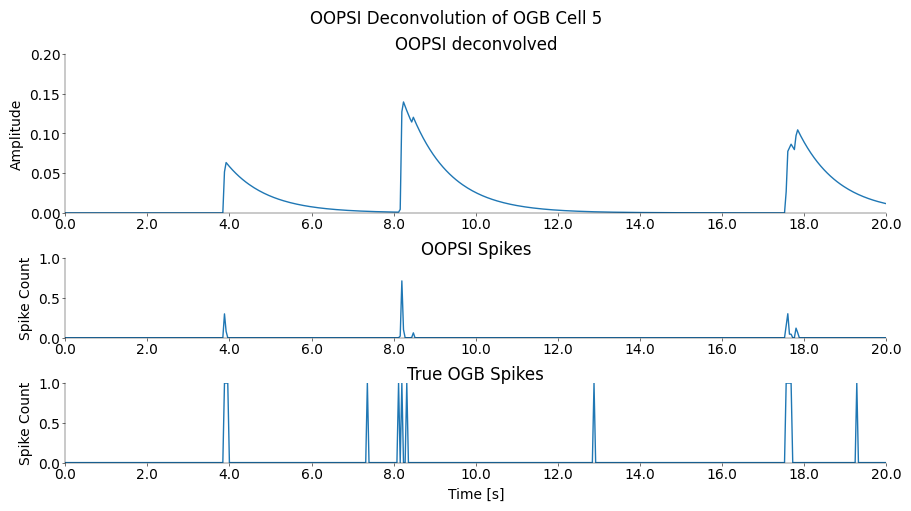

In [ ]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(9, 5), height_ratios=[2, 1, 1], layout="constrained"
)

axs[0].plot(np.arange(0, len(oopsi_ogb[1])), oopsi_ogb[1])
axs[0].set_title("OOPSI deconvolved")
axs[0].set_ylim(0, 0.2)
axs[0].set_ylabel("Amplitude")

axs[1].plot(np.arange(0, len(oopsi_ogb[0])), oopsi_ogb[0])
axs[1].set_title("OOPSI Spikes")
axs[1].set_ylim(0, 1)
axs[1].set_ylabel("Spike Count")

axs[2].plot(np.arange(0, len(ogb_cell_5_spikes)), ogb_cell_5_spikes)
axs[2].set_title("True OGB Spikes")
axs[2].set_ylim(0, 1)
axs[2].set_ylabel("Spike Count")


for ax in axs.flat:
    ax.set_xlim(0, 250)
    ax.set_xticks(np.arange(0, 501, 50))
    ax.set_xticklabels(np.arange(0, 501, 50) / 25)

plt.xlabel("Time [s]")
plt.suptitle("OOPSI Deconvolution of OGB Cell 5")

plt.show()

# OGB Cell

In [ ]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------

oopsi_gcamp = oopsi.fast(gcamp_cell_6_calcium, dt=dt)

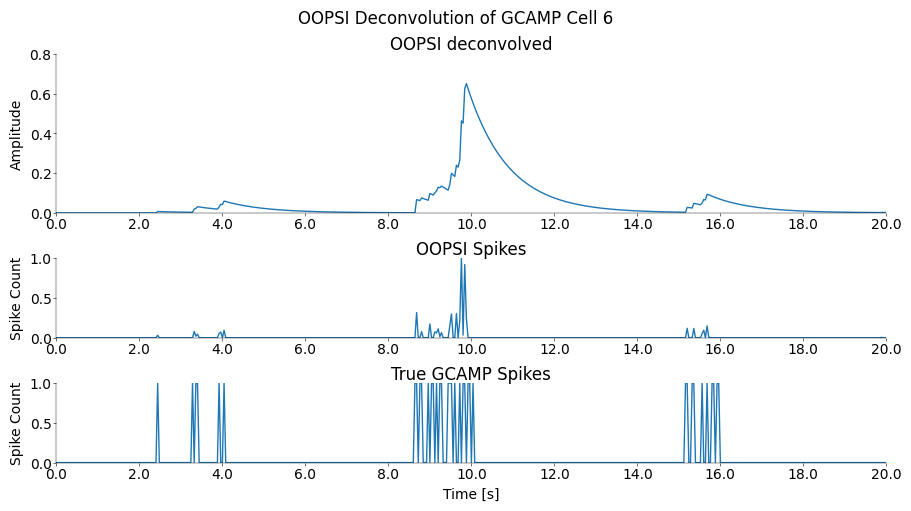

In [ ]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(9, 5), height_ratios=[2, 1, 1], layout="constrained"
)

axs[0].plot(np.arange(0, len(oopsi_gcamp[1])), oopsi_gcamp[1])
axs[0].set_title("OOPSI deconvolved")
axs[0].set_ylim(0, 0.8)
axs[0].set_ylabel("Amplitude")

axs[1].plot(np.arange(0, len(oopsi_gcamp[0])), oopsi_gcamp[0])
axs[1].set_title("OOPSI Spikes")
axs[1].set_ylim(0, 1)
axs[1].set_ylabel("Spike Count")

axs[2].plot(np.arange(0, len(gcamp_cell_6_spikes)), gcamp_cell_6_spikes)
axs[2].set_title("True GCAMP Spikes")
axs[2].set_ylim(0, 1)
axs[2].set_ylabel("Spike Count")


for ax in axs.flat:
    ax.set_xlim(0, 250)
    ax.set_xticks(np.arange(0, 501, 50))
    ax.set_xticklabels(np.arange(0, 501, 50) / 25)

plt.xlabel("Time [s]")
plt.suptitle("OOPSI Deconvolution of GCAMP Cell 6")

plt.show()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [ ]:
# First, we need to store all spike data for each cell for each of the algorithms
all_spikes = np.zeros_like(rs_ogb_spikes)
# Expand the dimensions
all_spikes = np.expand_dims(all_spikes, axis=-1)
# Repeat along the new dimension to get the desired shape (length, cell, 3)
all_spikes = np.repeat(all_spikes, 3, axis=-1)

# Then we need to compute the spike data for each cell
for col in range(rs_ogb_calcium.shape[1]):
    all_spikes[:, col, 0] = rs_ogb_spikes[:, col]  # save true spike data
    all_spikes[:-12, col, 1] = deconv_ca(
        rs_ogb_calcium[:, col], 0.5, dt
    )  # save deconvolved spike data; -12 because deconvolved data is shorter
    all_spikes[:, col, 2] = oopsi.fast(rs_ogb_calcium[:, col], dt)[
        0
    ]  # save oopsi spike data


deconvolve_corr = []
oopsi_corr = []

for col in range(all_spikes.shape[1]):
    deconvolve_corr.append(
        np.corrcoef(all_spikes[:, col, 0], all_spikes[:, col, 1])[0, 1]
    )
    oopsi_corr.append(np.corrcoef(all_spikes[:, col, 0], all_spikes[:, col, 2])[0, 1])

Create OGB dataframe

In [ ]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

# there is probably a nicer way but thats the easiest way to get the algorithm column labelled correctly
# if its stupid but it works it ain't stupid
ogb_df1 = pd.DataFrame(
    {"Correlation": deconvolve_corr, "Algorithm": "Deconvolve", "Indicator": "OGB"}
)
ogb_df2 = pd.DataFrame(
    {"Correlation": oopsi_corr, "Algorithm": "OOPSI", "Indicator": "OGB"}
)
ogb_df = combined_df = pd.concat([ogb_df1, ogb_df2])
ogb_df.head()

,Correlation,Algorithm,Indicator
0,0.311845,Deconvolve,OGB
1,0.135116,Deconvolve,OGB
2,0.160899,Deconvolve,OGB
3,0.229692,Deconvolve,OGB
4,0.229680,Deconvolve,OGB


Evaluate on GCamp data

In [ ]:
# First, we need to store all spike data for each cell for each of the algorithms
all_spikes = np.zeros_like(rs_gcamp_spikes)
# Expand the dimensions
all_spikes = np.expand_dims(all_spikes, axis=-1)
# Repeat along the new dimension to get the desired shape (length, cell, 3)
all_spikes = np.repeat(all_spikes, 3, axis=-1)

# Then we need to compute the spike data for each cell
for col in range(rs_gcamp_calcium.shape[1]):
    all_spikes[:, col, 0] = rs_gcamp_spikes[:, col]  # save true spike data
    all_spikes[:-12, col, 1] = deconv_ca(
        rs_gcamp_calcium[:, col], 0.5, dt
    )  # save decolvolved spike data; -12 because deconvolved data is shorter
    all_spikes[:, col, 2] = oopsi.fast(rs_gcamp_calcium[:, col], dt)[
        0
    ]  # save oopsi spike data

deconvolve_corr = []
oopsi_corr = []

for col in range(all_spikes.shape[1]):
    deconvolve_corr.append(
        np.corrcoef(all_spikes[:, col, 0], all_spikes[:, col, 1])[0, 1]
    )
    oopsi_corr.append(np.corrcoef(all_spikes[:, col, 0], all_spikes[:, col, 2])[0, 1])

Create GCamp dataframe

In [ ]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------
gcamp_df1 = pd.DataFrame(
    {"Correlation": deconvolve_corr, "Algorithm": "Deconvolve", "Indicator": "GCAMP"}
)
gcamp_df2 = pd.DataFrame(
    {"Correlation": oopsi_corr, "Algorithm": "OOPSI", "Indicator": "GCAMP"}
)
gcamp_df = combined_df = pd.concat([gcamp_df1, gcamp_df2])
gcamp_df.head()

,Correlation,Algorithm,Indicator
0,0.495777,Deconvolve,GCAMP
1,0.470537,Deconvolve,GCAMP
2,0.482738,Deconvolve,GCAMP
3,0.420938,Deconvolve,GCAMP
4,0.324284,Deconvolve,GCAMP


Combine both dataframes and plot

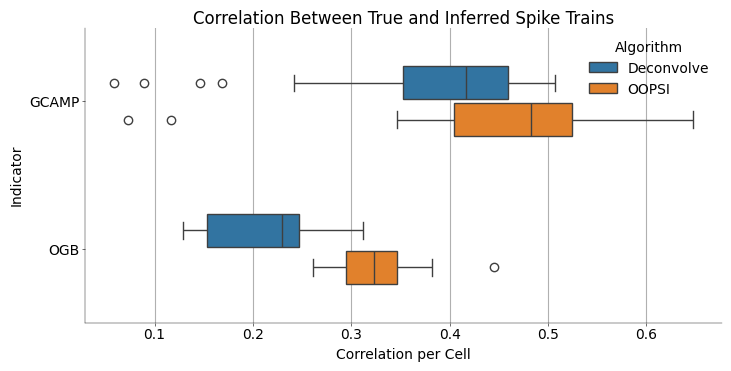

In [ ]:
combined_df = pd.concat([gcamp_df, ogb_df])

# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can separate the algorithms by color
# ---------------------------------------------------------------------------

ax = sns.boxplot(
    data=combined_df,
    x="Correlation",
    y="Indicator",
    hue="Algorithm",
    width=0.5,
    gap=0.1,
)
# vertical grid
ax.grid(axis="x")
ax.set_xlabel("Correlation per Cell")  # TODO passt das?
ax.set_title("Correlation Between True and Inferred Spike Trains")
plt.show()